In [15]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [16]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document

class State(TypedDict):
  question: str
  context: list[Document]
  response: str

### build retrieve node

In [17]:
import nest_asyncio
# nest async loop inside jupyter kernal 
nest_asyncio.apply()

In [18]:
# load pdf files
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader

directory_loader = DirectoryLoader("data", glob="**/*.pdf", loader_cls=PyMuPDFLoader)

loan_knowledge_resources = directory_loader.load()

In [19]:
len(loan_knowledge_resources)

269

In [20]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)

In [21]:
loan_knowledge_chunks = text_splitter.split_documents(loan_knowledge_resources)

In [22]:
len(loan_knowledge_chunks)

375

In [23]:
from langchain_openai.embeddings import OpenAIEmbeddings
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
embedding_dim =  1536

###  Qdrant vector db

In [24]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

In [25]:
client.create_collection(
    collection_name="loan_knowledge_index",
    vectors_config=VectorParams(size=embedding_dim, distance=Distance.COSINE),
)

True

In [26]:
vector_store = QdrantVectorStore(
    client=client,
    collection_name="loan_knowledge_index",
    embedding=embedding_model,
)

In [27]:
_ = vector_store.add_documents(documents=loan_knowledge_chunks)

### create retriever

In [28]:
retriever = vector_store.as_retriever(search_kwargs={"k": 5})

In [29]:
# create graph node 
def retrieve(state: State) -> State:
  retrieved_docs = retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

### create generate's chain components: prompt -> model -> parser

In [30]:
# chain components: chat template
from langchain_core.prompts import ChatPromptTemplate

HUMAN_TEMPLATE = """
#CONTEXT:
{context}

QUERY:
{query}

Use the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it's not contained in the provided context response with "I don't know"
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("human", HUMAN_TEMPLATE)
])

In [31]:
# chain components: GPT model, each runnable has "invoke" method
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4.1-nano")

### create generate node

In [32]:
from langchain_core.output_parsers import StrOutputParser

def generate(state: State) -> State:
  generator_chain = chat_prompt | openai_chat_model | StrOutputParser()
  response = generator_chain.invoke({"query" : state["question"], "context" : state["context"]})
  return {"response" : response}

### build graph

In [33]:
# Start with the blank canvas
graph_builder = StateGraph(State)
# automatically add edges between nodes and add end node
graph_builder = graph_builder.add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")

In [34]:
graph = graph_builder.compile()

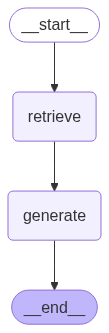

In [35]:
graph

In [36]:
from IPython.display import Markdown, display
response = graph.invoke({"question" : "Is applying for and securing a student loan in 2025 a terrible idea?"})
display(Markdown(response["response"]))

The provided context does not contain information regarding whether applying for and securing a student loan in 2025 is a terrible idea.

In [37]:
response = graph.invoke({"question" : "How much loan money can I actually get from the government to go to school these days? Is there a cap?"})
display(Markdown(response["response"]))

Based on the provided context, there are specific loan limits set by the government for undergraduate students. The maximum combined annual loan limit for a dependent first-year undergraduate is $5,500, with no more than $3,500 of that amount being subsidized. For students who have completed most of their program early, prorated limits are applied based on the number of clock hours completed. For example, if a student completes only 750 of the scheduled 900 clock hours, the prorated combined loan limit would be approximately $4,583, with a maximum of about $2,917 being subsidized.

Additionally, there are aggregate loan limits—total maximum amounts a student can borrow over time. For dependent undergraduates, the total subsidized and unsubsidized loan limit is $31,000, with no more than $23,000 subsidized; for independent undergraduates, it's $57,500 total, with the subsidized portion limited to $23,000.

In summary, the amount of loan money you can actually receive depends on your enrollment details, program length, and previous borrowing, but there are federal caps—both annual and total—governing the maximum loan amounts.